In [1]:
!pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


ERROR: Could not find a version that satisfies the requirement torch==1.4.0+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu113, 1.11.0+cu115, 1.12.0, 1.12.0+cpu, 1.12.0+cu113, 1.12.0+cu116, 1.12.1, 1.12.1+cpu, 1.12.1+cu113, 1.12.1+cu116, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 2.0.0, 2.0.0+cpu, 2.0.0+cu117, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cu117, 2.0.1+cu118, 2.1.0, 2.1.0+cpu, 2.1.0+cu118, 2.1.0+cu121, 2.1.1, 2.1.1+cpu, 2.1.1+cu118, 2.1.1+cu121, 2.1.2, 2.1.2+cpu, 2.1.2+cu118, 2.1.2+cu121, 2.2.0, 2.2.0+cpu, 2.2.0+cu118, 2.2.0+cu121)
ERROR: No matching distribution found for torch==1.4.0+cpu

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import argparse
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.vgg import vgg19

In [2]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cpu'):
        super(VGG19, self).__init__()
        features = list(vgg19().features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps

In [3]:
class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)
        # return fused_img

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output
        
        
    def _RGB_to_YCbCr(self, img_RGB):
            """
            A private method which converts an RGB image to YCrCb format
            """
            img_RGB = img_RGB.astype(np.float32) / 255.
            return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
            """
            A private method which converts a YCrCb image to RGB format
            """
            img_YCbCr = img_YCbCr.astype(np.float32)
            return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
            """
            A private method which returns True if image is gray, otherwise False
            """
            if len(img.shape) < 3:
                return True
            if img.shape[2] == 1:
                return True
            b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
            if (b == g).all() and (b == r).all():
                return True
            return False

    def _softmax(self, tensor):
            """
            A private method which compute softmax ouput of a given tensor
            """
            tensor = torch.exp(tensor)
            tensor = tensor / tensor.sum(dim=1, keepdim=True)
            return tensor

    def _tranfer_to_tensor(self):
            """
            A private method to transfer all input images to PyTorch tensors
            """
            self.images_to_tensors = []
            for image in self.normalized_images:
                np_input = image.astype(np.float32)
                if np_input.ndim == 2:
                    np_input = np.repeat(np_input[None, None], 3, axis=1)
                else:
                    np_input = np.transpose(np_input, (2, 0, 1))[None]
                if self.device == "cuda":
                    self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
                else:
                    self.images_to_tensors.append(torch.from_numpy(np_input)) 

In [4]:
# !pip install PyWavelets

Could not build wheels for PyWavelets, since package 'wheel' is not installed.
Could not build wheels for numpy, since package 'wheel' is not installed.


You should consider upgrading via the 'c:\users\kushal\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

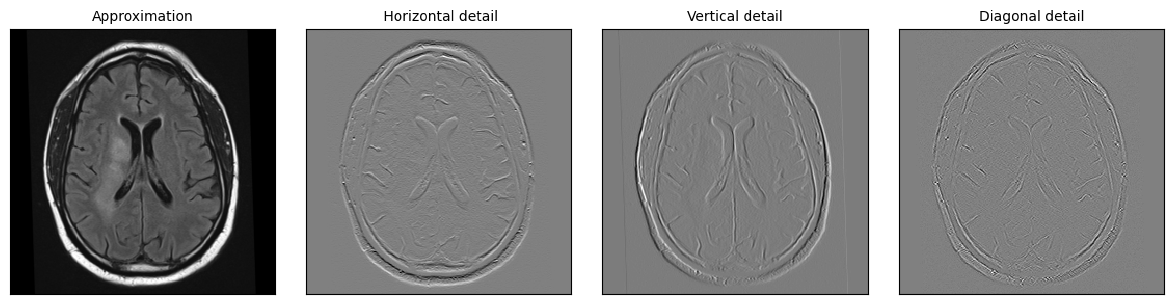

In [10]:
# Load MRI image
mri_image = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/dataset/Patient Data/p11/mri_registered.jpg')
mri_image = cv2.cvtColor(mri_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(mri_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_MRI11_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

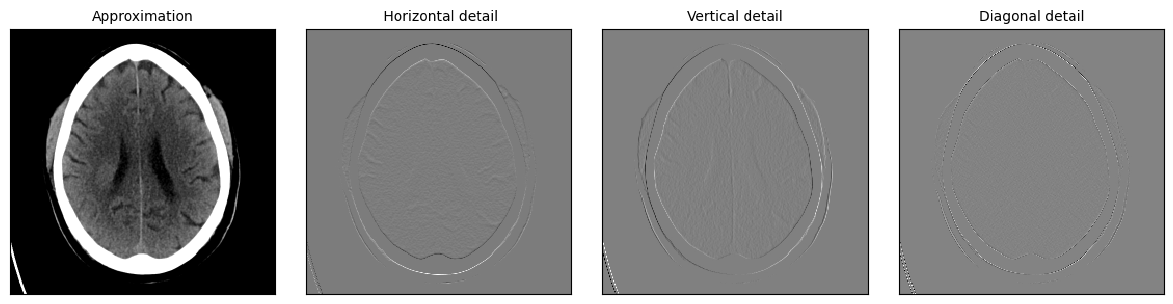

In [11]:
# Load CT Image
ct_image = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/multimodal-image-fusion-to-detect-brain-tumors-master/dataset/Patient Data/p11/ct.jpg')
ct_image = cv2.cvtColor(ct_image, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(ct_image, 'haar')

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    path='C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_CT11_'+str(i)+'.jpg'
    cv2.imwrite(path,a)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

#### Run VGG19 on the 4 bands of Images

In [12]:
# Calling the methods for Siamese on LL Images
input_images = []
mri = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_MRI11_0.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_CT11_0.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_0.jpg', fusion_img)

True

In [13]:
# Calling the methods for Siamese on LH Images
input_images = []
mri = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_MRI11_1.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_CT11_1.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_1.jpg', fusion_img)

True

In [14]:
# Calling the methods for Siamese on LV Images
input_images = []
mri = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_MRI11_2.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_CT11_2.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_2.jpg', fusion_img)

True

In [15]:
# Calling the methods for Siamese on LD Images
input_images = []
mri = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_MRI11_3.jpg')
mri = cv2.cvtColor(mri, cv2.COLOR_BGR2GRAY)

ct = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_CT11_3.jpg')
ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)

input_images.append(mri)
input_images.append(ct)

# Compute fusion image
FU = Fusion(input_images)
fusion_img = FU.fuse()
# Write fusion image
cv2.imwrite('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_3.jpg', fusion_img)

True

#### Reconstruction Using Inverse Wavelet Transform

In [16]:
fusion_0 = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_0.jpg')
fusion_0 = cv2.cvtColor(fusion_0, cv2.COLOR_BGR2GRAY)

fusion_1 = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_1.jpg')
fusion_1 = cv2.cvtColor(fusion_1, cv2.COLOR_BGR2GRAY)

fusion_2 = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_2.jpg')
fusion_2 = cv2.cvtColor(fusion_2, cv2.COLOR_BGR2GRAY)

fusion_3 = cv2.imread('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_fusion_3.jpg')
fusion_3 = cv2.cvtColor(fusion_3, cv2.COLOR_BGR2GRAY)

coeffs=(fusion_0,(fusion_1,fusion_2,fusion_3))

In [17]:
fusion=pywt.idwt2(coeffs,'haar')
cv2.imwrite('C:/Users/sivav/OneDrive/Documents/Final_year_proj/Testing_phase/Testing_final_fusion.jpg',fusion)

True